# Part 1 - Parse the DICOM images and Contour Files

**Pipeline Functions**
- Parse DICOM image
- Parse i-contour image
- Translate parsed i-contour image to boolean mask
- Make sure to pair the correct DICOM image with correct i-contour label

**Notes**
- Some DICOM images might contain missing label
- Some DICOM images might contain incorrect label

**Questions**
- How did you verify that you are parsing the contours correctly?
- What changes did you make to the code (if any) in order to integrate it into our production code base?

In [1]:
import os
import csv
import glob
import python_utils
import errno
import itertools
import pydicom
from pydicom.errors import InvalidDicomError
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
class DataReader(object):
    """DataReader is designed with the flexibility to prepare data for exploratory data analysis and deep learning model
      (1) Parse DICOM image, return image
      (2) Parse contour image, return list of coordinates
      (3) Translate contour image to boolean mask, return boolean mask
      (4) Pair correct DICOM image with correct i-contour label through available data and visualization (contour type)
      (5) Cache the pairs of DICOM numpy array and Boolean mask numpy array and write the pair list
      (6) Build mini-batches based on the training set assembled by (5)
    """
    _plots_colors = ['y', 'g', 'b', 'c', 'r']
    
    def __init__(self, base_data_path, pair_path,
                       contour_type='i-contours',
                       mini_batch_size=8,
                       save_plot=True):
        """
        :param data_path: string
            directory where all data is saved in local memory
        :param pair_path: string
            directory where paired dicom and boolean mask csv file is saved in local memory
        :param contour_type: string
            type of enum values it could handle: 'i-contour', 'o-contour', 'i-contour.o-contour'
        :param save_plot: bool
            enables whether to save the plots for debugging purposes in root directory
        """
        self.base_data_path = base_data_path
        self.pair_path = pair_path
        self.contour_type = contour_type
        self.mini_batch_size = mini_batch_size
        self.save_plot = save_plot
        
        self.base_dicom_path = os.path.join(base_data_path, 'dicoms')
        self.base_contour_path = os.path.join(base_data_path, 'contourfiles')
        self.base_link_path = os.path.join(base_data_path, 'link.csv')
    
    def _pair_dicom_contour(self):
        """
        Pair the DICOM file with the contour file (given filename)
        
        """
        csvFile = open(self.base_link_path)
        reader = csv.DictReader(csvFile, fieldnames=['patient_id','original_id'])
        next(reader)
        for row in reader:
            # Find the image identifiers given contour_type
            img_dir = os.path.join(self.base_dicom_path, row['patient_id'])
            img_fname = os.listdir(img_dir)
            img_id_set = set([ int(name.split('.')[0]) for name in img_fname ])

            contours_dirs = []
            contours_indices_sets = []
            for contour_type in self.contour_type.split('.'):
                contours_dir = os.path.join(self.base_contour_path, row['original_id'], contour_type)
                contours_dirs.append(contours_dir)
                contours_filenames = os.listdir(contours_dir)
                contours_indices_set = set([int(name.split('-')[2]) for name in contours_filenames ])
                contours_indices_sets.append(contours_indices_set)
            
            # pair_image_indices is a list of image indices having corresponding contour_type
            pair_imgs_indices = set.intersection(img_id_set, *contours_indices_sets)
            if len(pair_imgs_indices) == 0:
                continue

            # yield image and corresponding contour(s) pair
            for img_id in pair_imgs_indices:
                pair_img_path = glob.glob(os.path.join(img_dir, '{}.dcm'.format(img_id)))[0]
                pair_contours_paths = []
                contour_file_regex = '*{:04d}*'.format(img_id)
                for contours_dir in contours_dirs:
                    pair_contour_path = glob.glob(os.path.join(contours_dir, contour_file_regex))[0]
                    pair_contours_paths.append(pair_contour_path)

                yield pair_img_path, pair_contours_paths
    
    @staticmethod
    def _parse_dicom_file(filepath):
        """
        Parse a dicom file and return image data as python list

        :param filepath: string
            Path to the dicom file
        """
        try:
            dcm = pydicom.read_file(filepath)
            dcm_image = dcm.pixel_array

            try:
                intercept = dcm.RescaleIntercept
            except AttributeError:
                intercept = 0.0
            try:
                slope = dcm.RescaleSlope
            except AttributeError:
                slope = 0.0

            if intercept != 0.0 and slope != 0.0:
                dcm_image = dcm_image * slope + intercept
            return dcm_image
        except InvalidDicomError:
            raise None
            
    @staticmethod
    def _parse_contour_file(filepath):
        '''
        Parse the given contour filepath and return the list of tuples holding x,y coordinates of the contour.
        
        :param filepath: basestring
            Path to the contour file
        '''
        coords_lst = []
        with open(filepath, 'r') as infile:
            for line in infile:
                coords = line.strip().split()

                x_coord = float(coords[0])
                y_coord = float(coords[1])
                coords_lst.append((x_coord, y_coord))
                
        return coords_lst

    @staticmethod
    def _poly_to_mask(polygon, width, height):
        '''
        Convert a polygon to a mask, i.e., a boolean numpy array of shape(width, height)
        
        :param polygon: list
            list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
        :param width: scalar
            image width
        :param height: scalar
            image height
        '''

        # http://stackoverflow.com/a/3732128/1410871
        img = Image.new(mode='L', size=(width, height), color=0)
        ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
        mask = np.array(img).astype(bool)
        return mask
    
    @staticmethod
    def _plot_contour_overlay(img, contours, save_path):
        """
        Overlay the img and contour points in a single figure and save to local machine
        
        :param img: numpy array
        :param contours: list of 2D tuples
        :param save_path: string
            Path where the overlay figure is saved
        """
#         plt.clf()
        fig = plt.figure()
        plt.imshow(img)
        for idx, contour in enumerate(contours):
            x = [point[0] for point in contour]
            y = [point[1] for point in contour]
            color = DataReader._plots_colors[idx % len(DataReader._plots_colors)]
            plt.plot(x, y, alpha=1, color=color)
        fig.savefig(save_path)
        
    @staticmethod
    def _plot_mask_overlay(img, masks, save_path):
        """
        Overlay the img and mask in a single figure and save to local machine
        
        :param img: numpy array
        :param masks: list of numpy array
        :save_path: string
            Path where the overlay figure is saved
        """
#         plt.clf()
        fig = plt.figure()
        plt.imshow(img)
        for idx, mask in enumerate(masks):
            plt.imshow(mask, alpha=0.5)
        fig.savefig(save_path)
    
    @staticmethod
    def mkdir_p(path):
        """
        Recursively creates the directories in a given path

        :param path : str
            Path to the final directory to create.
        """
        try:
            os.makedirs(path)
        except OSError as exc:  # Python >2.5
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                raise

    def _read_dicom_contour(self):
        """
        Following method to call to 
        - Parse the dicom and contour pairs provided by _pair_dicom_contour method
        - Translate the contour files into corresponding mask files
        - Caches dicom files and contour files in numpy array format
        - Provide the list of dicom files and contour
        
        :param save_path: string
            Path where files are saved
        """
        
        # Set path string for output (valid dicom-mask pairs csv, images in numpy array format, 
        # masks in numpy array format, plots)
        save_path = os.getcwd() + '/_output/'
        plot_path = save_path + '_plots/'
        images_path = save_path + self.contour_type + '-images/'
        masks_path = save_path  + self.contour_type + '-masks/'
#         pair_path = save_path + 'img-mask-pair-file.csv'
        
        # Create directories for output
        DataReader.mkdir_p(save_path)
        DataReader.mkdir_p(plot_path)
        DataReader.mkdir_p(images_path)
        DataReader.mkdir_p(masks_path)
        
        dicom_contour_pairs = list(self._pair_dicom_contour())
        
        file = open(self.pair_path,'w')
        
        for index, (dicom_path, contour_paths) in enumerate(dicom_contour_pairs):
            try:
                img = DataReader._parse_dicom_file(dicom_path)
                contours, masks = [], []
                for contour_path in contour_paths:
                    contour = DataReader._parse_contour_file(contour_path)
                    mask = DataReader._poly_to_mask(contour, img.shape[0], img.shape[1])
                    contours.append(contour)
                    masks.append(mask)
            except InvalidDicomError:
                self.logger.error('Error loading dicom file: {}'.format(dicom_path), exc_info=True)
            else:
                # Create list of lines that indicate img_path, mask_1, mask_2, ...etc
                sample_pair = []

                # Save img to local machine
                img_path = os.path.join(images_path, '{}.npy'.format(index))
                sample_pair.append(img_path)
                np.save(img_path, img)

                for contour_type, mask in list(zip(self.contour_type.split('.'), masks)):
                    mask_path = os.path.join(masks_path, '{}.{}.npy'.format(index, contour_type))
                    sample_pair.append(mask_path)
                    np.save(mask_path, mask)

                # Save paths to file
                sample_pair = ' '.join(sample_pair)
                file.write('{}\n'.format(sample_pair))

                # Debugging Plotting: if save_plot=True, overlay img and (mask || contour)
                if self.save_plot and index < 10:
                    mask_overlay_path = os.path.join(plot_path + '',
                                                     '{}.mask_overlay.{}.jpg'.format(self.contour_type, index))
                    contour_overlay_path = os.path.join(plot_path,
                                                        '{}.contour_overlay.{}.jpg'.format(self.contour_type, index))
                    DataReader._plot_mask_overlay(img, masks, mask_overlay_path)
                    DataReader._plot_contour_overlay(img, contours, contour_overlay_path)
                    
        file.close()    
        
        

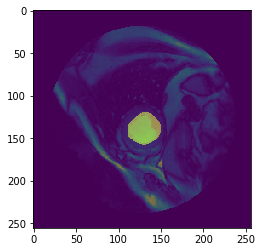

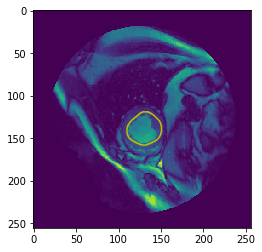

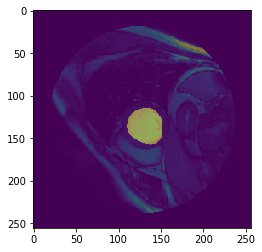

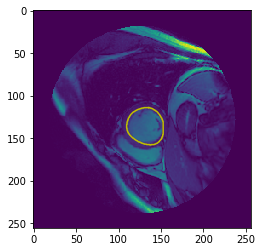

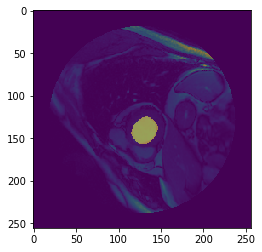

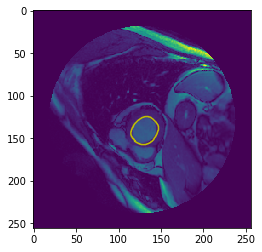

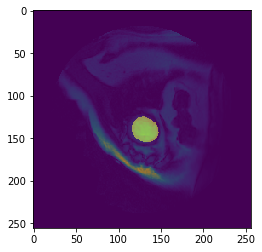

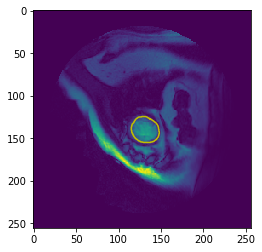

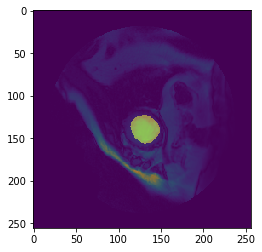

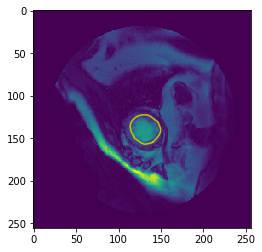

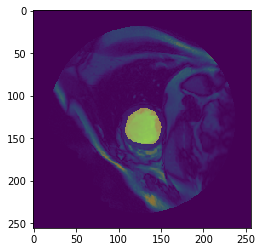

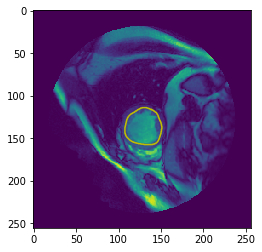

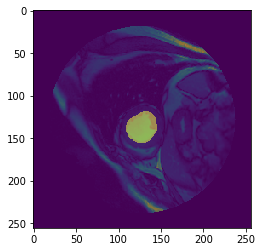

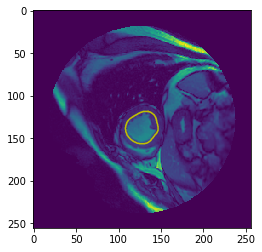

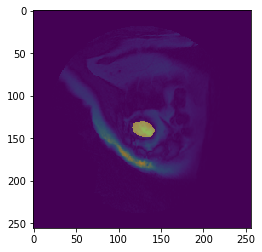

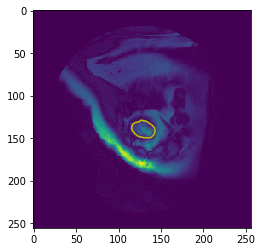

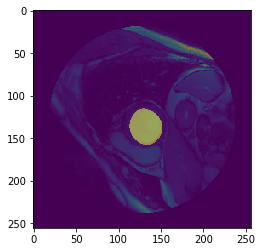

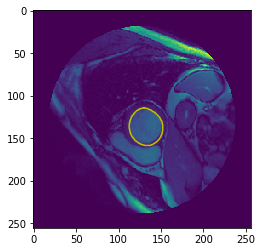

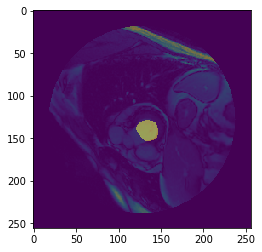

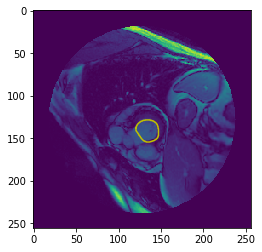

In [51]:
if __name__ == '__main__':
    data_reader = DataReader(base_data_path = './final_data/',
                             pair_path = './_output/img-mask-pair-file.csv',
                             contour_type='i-contours', 
                             save_plot=True)
    data_reader._read_dicom_contour()

# Part 2 - Model Training Pipeline

**Pipeline Functions (Continue)**
- Use saved info from DICOM image and contour file in numpy array
- Add one more step to the above pipeline to load batches of data into 2D Deep Learning Model (1) Cycles over batch (entire dataset) with mini-batches of size 8 (2) A single batch of data is composed of one numpy array of DICOM images and one numpy array of boolean masks (3) Within each epoch (iteration over all studies), samples from a batch should be loaded randomly from entire dataset

**Questions**
- Did you change anything from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that you can imagine changing in the future?
- How do you/did you verify that the pipeline was working correctly?
- Given the pipeline you have built, can you see any deficiencies that you would change if you had more time? If not, can you think of any improvements/enhancements to the pipeline that you could build in?

### Did you change anything from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that you can imagine changing in the future?
- Given a better system design approach, I wanted to keep the pipeline from Part 1 as it is since the Part 1 block communicates to the Part 2 block through the saved files on the local machine. It also provides a clean way to debug the input/output of Block 1 vs input/output of Block 2
- Perhaps I can add another parameter to the DataReader where I can analyze a subset of patients

### How do you/did you verify that the pipeline was working correctly?
- Checked the data shapes and types are consistent for Block 1 of Pipeline and Block 2 of Pipeline
- Also generated and checked plots after shuffling the batch and partitioning it

### Given the pipeline you have built, can you see any deficiencies that you would change if you had more time? If not, can you think of any improvements/enhancements to the pipeline that you could build in?
- If I had more time, I would like to provide more conditions to avoid edge cases and perhaps more helper functions in the image preprocessing step that deal with resampling, normalizing, etc. I would also like to generate more unit tests for each method of class.